In [17]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

I don't have any GPU on my computer, so every train will be done with few epochs.

# 1 - Loading and preprocessing

In [18]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/train/'
validation_data_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/test/'

We can see a lot of noise in pictures (many pictures are not in the right group).

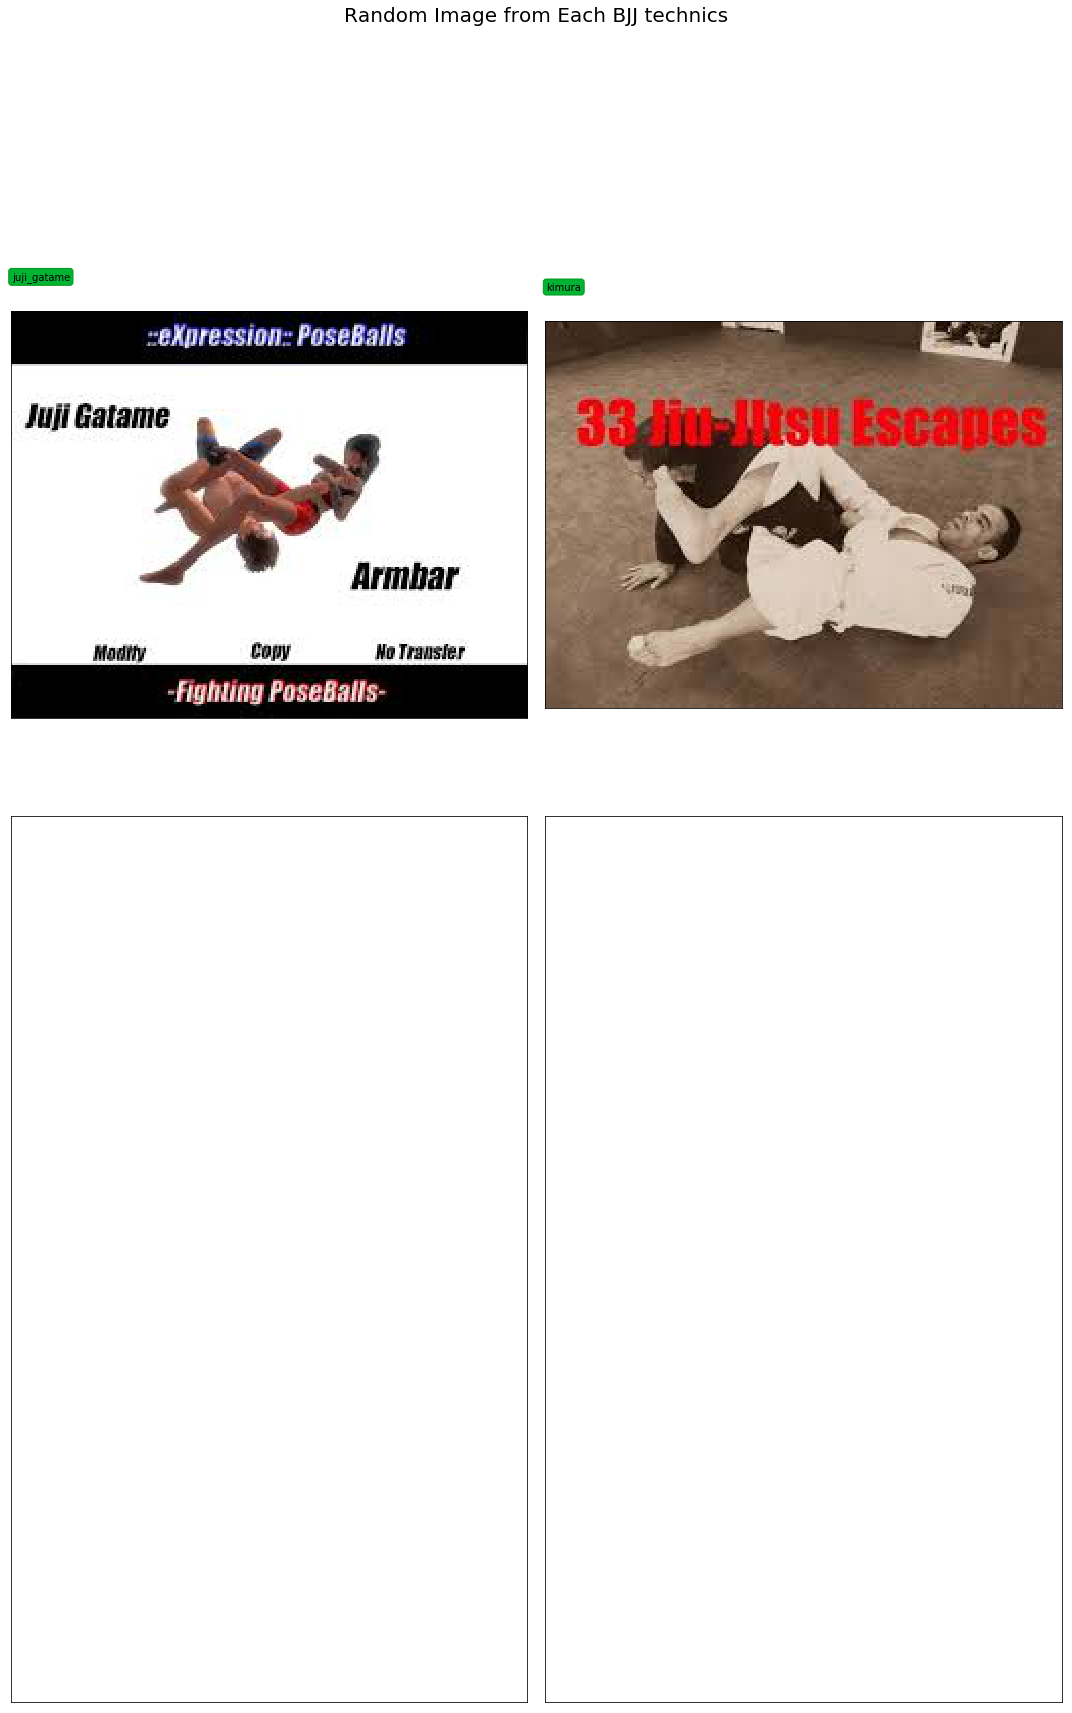

In [19]:
root_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/train/'
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each BJJ technics', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

We created batch of tensor Images. Image are looped over indefinitely.

In [20]:
##preprocessing
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 227 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


# 2 - Layers construction

In [21]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# 3 - Training

In [23]:
epochs = 1
train_samples = 2048
validation_samples = 832

In [24]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples// batch_size,)
#About 60 seconds an epoch when using CPU

Epoch 1/1
64/64 [==============================] - 76s - loss: 0.5314 - acc: 0.7407 - val_loss: 0.6369 - val_acc: 0.6732


In [25]:
model.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/basic_cnn_30_epochs.h5')

# 4 - Evaluation

In [26]:
model.load_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/basic_cnn_30_epochs.h5')

In [27]:
model.evaluate_generator(validation_generator, validation_samples)

[0.6365551964447993, 0.67328506138448307]

In [28]:
model.metrics_names

['loss', 'acc']

# 5 - Data augmentation

In [29]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 227 images belonging to 2 classes.


In [30]:
model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/1
64/64 [==============================] - 61s - loss: 0.4568 - acc: 0.7943 - val_loss: 0.6228 - val_acc: 0.6756


In [31]:
model.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/augmented_30_epochs.h5')

In [32]:

model.evaluate_generator(validation_generator, validation_samples)

[0.60301631636826736, 0.68311737811692608]

# 6 - Using a pre-trained models

###### VGG16

In [33]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

###### Process sample with VGG16

In [34]:
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 227 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [35]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_train.npy', 'wb'), 
        bottleneck_features_train)

In [36]:
bottleneck_features_validation =\
    model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
np.save(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_validation.npy', 'wb'), 
        bottleneck_features_validation)

In [37]:
train_data = np.load(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_train.npy', 
                          'rb'))
train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))

validation_data = np.load(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_validation.npy', 
                               'rb'))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

In [38]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model_top.fit(train_data, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_data, validation_labels))

ValueError: Input arrays should have the same number of samples as target arrays. Found 1816 input samples and 2048 target samples.

In [ ]:
model_top.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_30_epochs.h5')

###### Bottleneck model evaluation

In [ ]:
model_top.evaluate(validation_data, validation_labels)